In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.models as models
import random as random

In [2]:
n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def get_mnist(location="./", batch_size=128):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms
    
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    
    img_transform = lambda x: compose(x).view(-1)
    

    mnist_train = MNIST(location, train=True, download=True,transform=img_transform, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,transform=img_transform, target_transform=onehot(n_labels))

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size)

    return labelled, validation

In [3]:
labelled, valid = get_mnist()

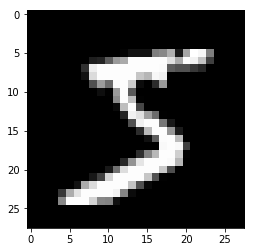

In [4]:
plt.imshow(next(iter(labelled))[0][0].view(28,28), cmap='gray')

In [5]:
class Generator(nn.Module):
    def __init__(self, in_dim=110, out_dim=784, d=128):
        super().__init__()
#         self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=256, out_features=512),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=512, out_features=1024),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Linear(in_features=1024, out_features=out_dim),
#                                  nn.Tanh())

        self.net = nn.Sequential(nn.ConvTranspose2d(in_channels=100, out_channels=d*4, kernel_size=4, stride=1, padding=0),
                         nn.BatchNorm2d(d*4),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d*4, out_channels=d*2, kernel_size=4, stride=2, padding=1),
                         nn.BatchNorm2d(d*2),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d*2, out_channels=d, kernel_size=3, stride=2, padding=1),
                         nn.BatchNorm2d(d),
                         nn.ReLU(),
                         nn.ConvTranspose2d(in_channels=d, out_channels=1, kernel_size=2, stride=2, padding=1),
                         nn.Tanh())
    
        self.linear = nn.Linear(in_features=in_dim, out_features=100)
        
    def forward(self,x):
        x = self.linear(x).view(-1,100,1,1)
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=794, d=128):
        super().__init__()
#         self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=1024),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=1024, out_features=512),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=512, out_features=256),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(in_features=256, out_features=1),
#                                  nn.Sigmoid())
        self.net = nn.Sequential(nn.Conv2d(1, d, 2, 2, 1),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d, d*2, 3, 2, 1),
                                 nn.BatchNorm2d(d*2),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d*2, d*4, 4, 2, 1),
                                 nn.BatchNorm2d(d*4),
                                 nn.LeakyReLU(0.2),
                                 nn.Conv2d(d*4, 1, 4, 1, 0),
                                 nn.Sigmoid())
        self.linear = nn.Linear(in_features=in_dim, out_features=784)
        
    def forward(self,x):
        x = self.linear(x).view(-1,1,28,28)
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [7]:
class Classifier(nn.Module):
    def __init__(self, in_dim=784):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=10),
                                 nn.LogSoftmax(dim=-1))
        
    def forward(self,x):        
        return self.net(x)

In [8]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

generator = Generator()
discriminator = Discriminator()

generator.weight_init(mean=0.0, std=0.02)
discriminator.weight_init(mean=0.0, std=0.02)

generator = generator.to(device)
discriminator = discriminator.to(device)
classifier = Classifier().to(device)

In [9]:
x = torch.rand(100).to(device)
label = onehot(10)(random.randint(0,9)).to(device)
x = torch.cat((x, label))

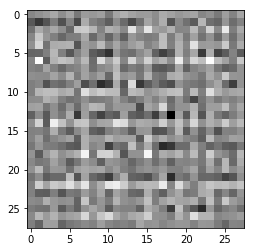

In [10]:
plt.imshow(generator(x).view(28,28).cpu().detach(), cmap='gray')

In [11]:
discriminator(torch.cat((generator(x).view(-1), label)))

tensor([[[[0.5009]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [12]:
classifier(generator(x).view(-1))

tensor([-2.3584, -2.3840, -2.2602, -2.3110, -2.2473, -2.3180, -2.2410, -2.2755,
        -2.3549, -2.2868], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [13]:
optimizerD = torch.optim.SGD(discriminator.parameters(), lr=0.01)
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizerC = torch.optim.Adam(classifier.parameters(), lr=0.0002)

In [14]:
def to_variable(x):
    '''
    convert a tensor to a variable
    with gradient tracking
    '''
    x = x.to(device)
    return Variable(x)

In [15]:
BCE = nn.BCELoss()
NLL = nn.NLLLoss()
MSE = nn.MSELoss()
NUM_EPOCH = 20

def train():
    loss_g, loss_d, loss_c = [], [], []
    for epoch in range(NUM_EPOCH):
        
        for idx, batch_data in enumerate(labelled):
            
            
            batch_size = batch_data[0].shape[0]
            
            # create label for discriminative part
            fake_labels = to_variable(torch.zeros(batch_size, 1))
            true_labels = to_variable(torch.ones(batch_size, 1))
            
            
            # retrieve real data from loader
            real_images = to_variable(batch_data[0])
            classes_real = to_variable(batch_data[1])  
            
            # create fake data with generator
            noise = to_variable(torch.randn(batch_size, 100))
            classes_fake = to_variable(torch.stack(list
                                                   (map(lambda x: onehot(10)(x), 
                                                        list(np.random.randint(10, size=batch_size))))))
            fake_images = generator(torch.cat((noise, classes_fake), -1)).view(batch_size,-1)
            
#             # Train classifier on fake and real data
#             prediction_real = classifier(real_images)
# #             print(prediction_real)
#             prediction_fake = classifier(fake_images.detach())
            
#             lossC_real = NLL(prediction_real, classes_real.argmax(dim=-1))
#             lossC_fake = NLL(prediction_fake, classes_fake.argmax(dim=-1))
            
#             lossC = lossC_real + lossC_fake
            
#             lossC.backward()
            
#             optimizerC.step()
            
            # Train discriminator on real data 
            discriminator.zero_grad()
            
            outputs_real = discriminator(torch.cat((real_images, classes_real), -1))
            
            lossD_real = BCE(outputs_real, true_labels)

            lossD_real.backward()

            
            # Train discriminator on fake data 
            
            
            outputs_fake_d = discriminator(torch.cat((fake_images.detach(), classes_fake), -1))
            lossD_fake = BCE(outputs_fake_d, fake_labels)


            lossD_fake.backward()
            

            lossD = lossD_fake + lossD_real

            optimizerD.step()
            
            # Train generator
            generator.zero_grad()
            noise = to_variable(torch.randn(batch_size, 100))
            fake_images = generator(torch.cat((noise, classes_fake), -1)).view(batch_size,-1)
            outputs_fake_g = discriminator(torch.cat((fake_images, classes_fake), -1))
            lossG =  BCE(outputs_fake_g, true_labels)

            lossG.backward()
            
            loss_d.append(lossD.item())
            loss_g.append(lossG.item())
#             loss_c.append(lossC.item())

            optimizerG.step()
            
    
    
    
        print("Epoch: ", epoch, ", Gloss: ", np.mean(loss_g[:-10]), ", Dloss: ", np.mean(loss_d[:-10]))#, ", Closs: ", np.mean(loss_c[:-10]))
#       print("Epoch: ", epoch, ", Gloss: ", np.mean(loss_g[:-10]), ", Dloss: ", np.mean(loss_d[:-10]), ", Closs: ", np.mean(loss_c[:-10]))
            

In [16]:
train()

/home/pierre/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/pierre/.local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  0 , Gloss:  5.633540062064287 , Dloss:  0.6085491283121569
Epoch:  1 , Gloss:  5.142692525589923 , Dloss:  0.5087946474890612
Epoch:  2 , Gloss:  4.716232832590585 , Dloss:  0.5342822229642515
Epoch:  3 , Gloss:  4.406622265237008 , Dloss:  0.5488036780425104
Epoch:  4 , Gloss:  4.198016811488526 , Dloss:  0.5635391840001776
Epoch:  5 , Gloss:  3.926062954793685 , Dloss:  0.6003540816113433


KeyboardInterrupt: 

In [20]:
x = torch.rand(100,100).to(device)
label = torch.stack(list(map(lambda x: onehot(10)(x),[int(i/10) for i in range(100)]))).to(device)
x = torch.cat((x, label),-1)
x.shape

torch.Size([100, 110])

In [21]:
generator(x).shape

torch.Size([100, 1, 28, 28])

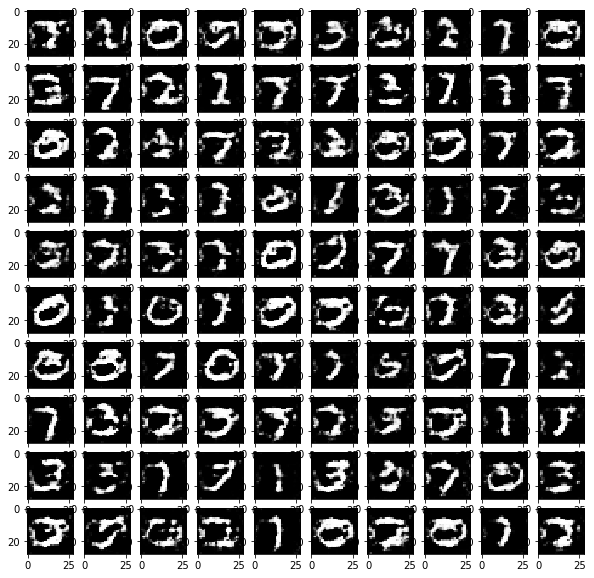

In [22]:
plt.figure(figsize=(10,10))

for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(generator(x)[10*i+j].view(28,28).cpu().detach(), cmap='gray')

In [ ]:
classes_fake = to_variable(torch.stack(list
                                                   (map(lambda x: onehot(10)(x), 
                                                        list(np.random.randint(10, size=10))))))
classes_fake

In [ ]:
torch.max(classes_fake, -1)[1]

In [ ]:
def test():
    r =0
    length = 0 
    for idx, batch_data in enumerate(valid):
        batch_size = batch_data[0].shape[0]
        real_images = batch_data[0].cuda()
        classes_real = batch_data[1].cuda()
#         print(classes_real.argmax(dim=-1))

        predictions_real = classifier(real_images).argmax(dim=-1)
#         print(predictions_real)
#         r += torch.sum(abs(predictions_real-classes_real)).item()
        r += predictions_real.eq(classes_real.argmax(dim=-1)).sum().item()
        length += batch_size
    return r/length

In [ ]:
test()